In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
img = cv2.imread('/content/download.png')

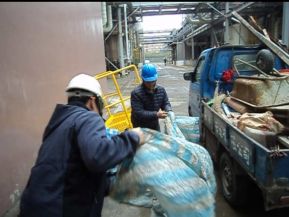

In [ ]:
cv2_imshow(img)

In [ ]:
img.shape

(217, 289, 3)

In [ ]:
# Object information: a set of bounding boxes [ymin, xmin, ymax, xmax] and their labels 
bb_vals = np.array([[72, 62, 98, 105], [60, 136, 84, 161]]) 
labels = np.array([1, 1]) # 0: background, 1: helmet

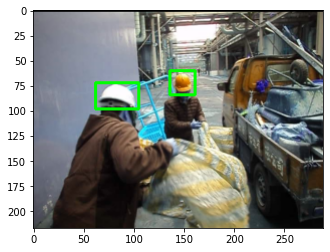

In [ ]:
# display bounding box and labels
img_copy = np.copy(img)
for i in range(len(bb_vals)):
    cv2.rectangle(img_copy, (bb_vals[i][1], bb_vals[i][0]), (bb_vals[i][3], bb_vals[i][2]), color=(0, 255, 0), thickness=2) 
    #cv2.putText(img_copy, str(int(labels[i])), (bb_vals[i][3], bb_vals[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) 
plt.imshow(img_copy)
plt.show()

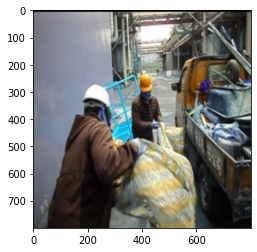

In [ ]:
img_resize = cv2.resize(img, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.imshow(img_resize)
plt.show()

In [ ]:
Wratio = 800/img.shape[1]
Hratio = 800/img.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bb_resizedval = []
for box in bb_vals:
    box = [int(a * b) for a, b in zip(box, ratioLst)] 
    bb_resizedval.append(box)
bb_resizedval = np.array(bb_resizedval)
print(bb_resizedval)

[[265 171 361 290]
 [221 376 309 445]]


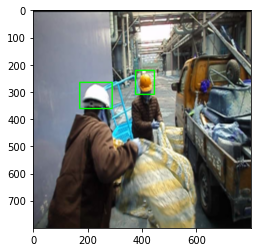

In [ ]:
img_copy = np.copy(img_resize)
bbox_copy = bb_resizedval.astype(int)
for i in range(len(bb_resizedval)):
    cv2.rectangle(img_copy, (bb_resizedval[i][1], bb_resizedval[i][0]), (bb_resizedval[i][3], bb_resizedval[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    #cv2.putText(img_clone, str(int(labels[i])), (bbox[i][3], bbox[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) # Write the prediction class
plt.imshow(img_copy)
plt.show()    


In [ ]:
model = torchvision.models.vgg16(pretrained=True)
features_map_size = list(model.features)
print(len(features_map_size))

31


In [ ]:
from torchsummary import summary
summary(model, (3, 800, 800))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 800, 800]           1,792
              ReLU-2         [-1, 64, 800, 800]               0
            Conv2d-3         [-1, 64, 800, 800]          36,928
              ReLU-4         [-1, 64, 800, 800]               0
         MaxPool2d-5         [-1, 64, 400, 400]               0
            Conv2d-6        [-1, 128, 400, 400]          73,856
              ReLU-7        [-1, 128, 400, 400]               0
            Conv2d-8        [-1, 128, 400, 400]         147,584
              ReLU-9        [-1, 128, 400, 400]               0
        MaxPool2d-10        [-1, 128, 200, 200]               0
           Conv2d-11        [-1, 256, 200, 200]         295,168
             ReLU-12        [-1, 256, 200, 200]               0
           Conv2d-13        [-1, 256, 200, 200]         590,080
             ReLU-14        [-1, 256, 2

In [ ]:
# collect layers with output feature map size (W, H) < 50
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array [1, 3, 800, 800] 

req_features = []
k = dummy_img.clone()
for i in features_map_size:
    k = i(k)
    if k.size()[2] < 800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]

print(out_channels) 

512


In [ ]:
# Convert this list into a Sequential module
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

In [ ]:
transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
imgTensor = transform(img_resize)
imgTensor = imgTensor.unsqueeze(0)
result_feature_map = faster_rcnn_fe_extractor(imgTensor)
print(result_feature_map.size())

torch.Size([1, 512, 50, 50])


In [ ]:
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)

In [ ]:
print(len(ctr_x), ctr_x)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [ ]:
print(len(ctr_y), ctr_y)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [ ]:
img_copy2 = np.copy(img_resize)
for i in range(50):
  cv2.circle(img_copy2, (ctr_x[i], ctr_y[i]), radius = 1, color = (255, 0, 0), thickness = 2)

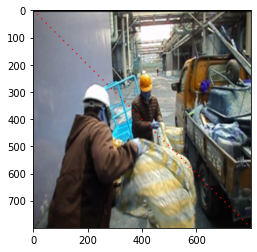

In [ ]:
plt.imshow(img_copy2)

In [ ]:
# coordinates of the 2500 center points to generate anchor boxes
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index +=1
print(ctr.shape)

(2500, 2)


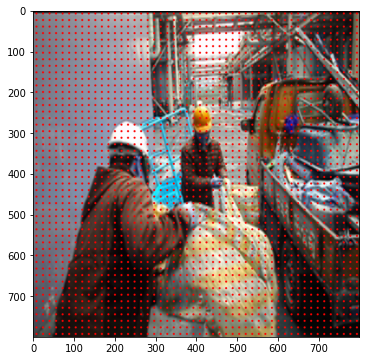

In [ ]:
img_clone = np.copy(img_resize)
plt.figure(figsize=(9, 6))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(255, 0, 0), thickness=2) 
plt.imshow(img_clone) 

In [ ]:
aspect_ratio = [0.5, 1, 2]
anchor_scales = [8, 16, 32]

anchor_base = np.zeros((len(aspect_ratio) * len(anchor_scales), 4), dtype=np.float32)

print(anchor_base)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [ ]:
print(anchor_base.shape)

(9, 4)


In [ ]:
sub_sample = 16
anchor_boxes = np.zeros( ((50 * 50 * 9), 4))

In [ ]:
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(aspect_ratio)):
        for j in range(len(anchor_scales)):
            h = sub_sample * anchor_scales[j] * np.sqrt(aspect_ratio[i])
            w = sub_sample * anchor_scales[j] * np.sqrt(1./ aspect_ratio[i])
            anchor_boxes[index, 0] = ctr_y - h / 2.
            anchor_boxes[index, 1] = ctr_x - w / 2.
            anchor_boxes[index, 2] = ctr_y + h / 2.
            anchor_boxes[index, 3] = ctr_x + w / 2.
            index += 1
print(anchor_boxes.shape)

(22500, 4)


In [ ]:
img_copy3 = np.copy(img_resize)
for i in range(11025, 11034):  #9*1225=11025
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_copy3, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bb_resizedval)):
    cv2.rectangle(img_copy3, (bb_resizedval[i][1], bb_resizedval[i][0]), (bb_resizedval[i][3], bb_resizedval[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    

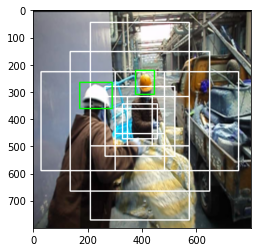

In [ ]:
plt.imshow(img_copy3)

In [ ]:
index_inside = np.where((anchor_boxes[:, 0] >= 0) & (anchor_boxes[:, 1] >= 0) & (anchor_boxes[:, 2] <= 800) & (anchor_boxes[:, 3] <= 800))[0]
print(index_inside.shape)

(8940,)


In [ ]:
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940, 4)


In [ ]:
iou_vals = np.zeros((len(valid_anchor_boxes), 2), dtype=np.float32)

In [ ]:
iou_vals

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [ ]:
for index, dim_anchor in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = dim_anchor 
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for index_gt, dim_anchor_gt in enumerate(bb_resizedval):
        yb1, xb1, yb2, xb2 = dim_anchor_gt
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)          
        else:
            iou = 0.
        iou_vals[index, index_gt] = iou

In [ ]:
gt_argmax_ious = iou_vals.argmax(axis=0)
print(gt_argmax_ious)

[1822 3734]


In [ ]:
gt_max_ious = iou_vals[gt_argmax_ious, np.arange(iou_vals.shape[1])]
print(gt_max_ious)

[0.6972656  0.37060547]


In [ ]:
gt_argmax_ious = np.where(iou_vals == gt_max_ious)[0]
print(gt_argmax_ious)

[1822 1828 3734 3985 4255 4259 4262 4270 4524 4529 4531 4533 4536 4539
 4544 4547 4555 4803 4807 4810 4818 5072 5076 5078 5085 5322]


In [ ]:
argmax_ious = iou_vals.argmax(axis=1)
print(argmax_ious)
max_ious = iou_vals[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [ ]:
label[gt_argmax_ious] = 1

In [ ]:
label[max_ious >= 0.7] = 1
label[max_ious < 0.3] = 0

In [ ]:
no_of_samples = 256
no_of_pos_samples = 0.5 * no_of_samples

In [ ]:
pos_index = np.where(label == 1)[0]

In [ ]:
pos_index

array([1822, 1828, 3734, 3985, 4255, 4259, 4262, 4270, 4524, 4529, 4531,
       4533, 4536, 4539, 4544, 4547, 4555, 4803, 4807, 4810, 4818, 5072,
       5076, 5078, 5085, 5322])

In [ ]:
if len(pos_index) > no_of_pos_samples:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - no_of_pos_samples), replace=False)
    label[disable_index] = -1

In [ ]:
no_of_neg_samples = no_of_samples * np.sum(label == 1)

In [ ]:
no_of_neg_samples

6656

In [ ]:
neg_index = np.where(label == 0)[0]

In [ ]:
if len(neg_index) > no_of_neg_samples:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - no_of_neg_samples), replace = False)
    label[disable_index] = -1

In [ ]:
max_iou_bbox = bb_resizedval[argmax_ious]
print(max_iou_bbox.shape)

(8940, 4)


In [ ]:
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

In [ ]:
base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

In [ ]:
base_height.shape

(8940,)

In [ ]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps) #讓 height !=0, 最小值為 eps
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)

(8940, 4)


In [ ]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)

(22500,)
(22500, 4)


In [ ]:
in_channels = 512 
out_channels = 512
no_of_anchors = 9  

conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(out_channels, no_of_anchors *4, 1, 1, 0)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(out_channels, no_of_anchors *2, 1, 1, 0)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
x = conv1(result_feature_map) # result_feature_map = faster_rcnn_fe_extractor(imgTensor)
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [ ]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous().view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [ ]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

In [ ]:
gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

In [ ]:
print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [ ]:
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long(), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.6975, grad_fn=<NllLossBackward>)


In [ ]:
pos = gt_rpn_score > 0
print(pos.shape)
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

torch.Size([22500])
torch.Size([22500, 4])


In [ ]:
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

torch.Size([26, 4]) torch.Size([26, 4])


In [ ]:
x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(rpn_loc_loss.sum())

tensor(8.3392, dtype=torch.float64, grad_fn=<SumBackward0>)


In [ ]:
rpn_lambda = 10.
N_reg = (gt_rpn_score >0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(3.9049, dtype=torch.float64, grad_fn=<AddBackward0>)


In [ ]:
nms_thresh = 0.7  # non-maximum supression (NMS) 
n_train_pre_nms = 12000 # no. of train pre-NMS
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 6000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [ ]:
# format converted from [y1, x1, y2, x2] to [ctr_x, ctr_y, h, w]
anc_height = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_width = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_ctr_y = anchor_boxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 1] + 0.5 * anc_width
print(anc_ctr_x.shape)

(22500,)


In [ ]:
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()
dy = pred_anchor_locs_numpy[:, 0::4]
dx = pred_anchor_locs_numpy[:, 1::4] 
dh = pred_anchor_locs_numpy[:, 2::4] 
dw = pred_anchor_locs_numpy[:, 3::4] 
print(dy.shape)

# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500, 1)
(22500, 1)


In [ ]:
roi_vals = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi_vals[:, 0::4] = ctr_y - 0.5 * h
roi_vals[:, 1::4] = ctr_x - 0.5 * w
roi_vals[:, 2::4] = ctr_y + 0.5 * h
roi_vals[:, 3::4] = ctr_x + 0.5 * w
print(roi_vals.shape)

(22500, 4)


In [ ]:
img_size = (800, 800)

In [ ]:
roi_vals[:, slice(0, 4, 2)] = np.clip(roi_vals[:, slice(0, 4, 2)], 0, img_size[0])
roi_vals[:, slice(1, 4, 2)] = np.clip(roi_vals[:, slice(1, 4, 2)], 0, img_size[1])

In [ ]:
h_pred = roi_vals[:, 2] - roi_vals[:, 0]
w_pred = roi_vals[:, 3] - roi_vals[:, 1]
keep = np.where((h_pred >= min_size) & (w_pred >= min_size))[0] #min_size=16
roi_vals = roi_vals[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi_vals.shape, score.shape)

(22500,) (22500, 4) (22500,)


In [ ]:
order = score.ravel().argsort()[::-1]
print(order.shape)
#Take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi_vals = roi_vals[order, :]
print(order.shape, roi_vals.shape)

(22500,)
(12000,) (12000, 4)


In [ ]:
y1 = roi_vals[:, 0]
x1 = roi_vals[:, 1]
y2 = roi_vals[:, 2]
x2 = roi_vals[:, 3]
areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [ ]:
areas.shape

(12000,)

In [ ]:
#Take the indexes of order the probability score in descending order 
order = order.argsort()[::-1]
keep = []
while (order.size > 0):
    i = order[0] #take the 1st elt in order and append to keep 
    keep.append(i)
    xx1 = np.maximum(x1[i], x1[order[1:]]) 
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]
keep = keep[:n_train_post_nms] # while training/testing , use accordingly
roi_vals = roi_vals[keep] # the final region proposals
print(len(keep), roi_vals.shape)

2000 (2000, 4)


In [ ]:
n_sample = 128  # Number of samples from roi 
pos_ratio = 0.25 # Number of positive examples out of the n_samples
pos_iou_thresh = 0.5  # Min iou of region proposal with any groundtruth object to consider it as positive label
neg_iou_thresh_hi = 0.5  # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [ ]:
ious = np.zeros((len(roi_vals), 2), dtype=np.float32)

for num1, i in enumerate(roi_vals):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bb_resizedval):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(2000, 2)


In [ ]:
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)
print(gt_assignment)
print(max_iou)

[0 0 0 ... 0 0 0]
[0.         0.         0.         ... 0.27569208 0.2541339  0.14546461]


In [ ]:
gt_assignment.shape

(2000,)

In [ ]:
max_iou.shape

(2000,)

In [ ]:
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[1 1 1 ... 1 1 1]


In [ ]:
# Select the foreground rois as per the pos_iou_thesh and 
# n_sample x pos_ratio (128 x 0.25 = 32) foreground samples.

pos_roi_per_image = 32 
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(pos_index, size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)

# Similarly we do for negitive (background) region proposals
neg_index = np.where((max_iou < neg_iou_thresh_hi) & (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
if  neg_index.size > 0 :
    neg_index = np.random.choice(neg_index, size=neg_roi_per_this_image, replace=False)
print(neg_roi_per_this_image)
print(neg_index)

2
[1991 1930]
126
[ 704 1686 1494  592  463  783 1286 1711 1164  718 1879  843  742  435
  664  676 1981 1445  446 1229  276  767  569 1358 1998 1808  771 1784
 1325 1153  247 1192 1893 1383 1907  122  800 1062 1226  233  957  985
 1008 1063  572 1719 1613 1245  348  917 1554 1821 1240 1248  818 1540
  162  868  673 1843 1278 1732  687 1529   51 1980  875 1377 1308  609
 1442 1337  176 1736 1291 1448 1690 1341 1678 1481  863  661 1895  427
 1067 1231  577 1393 1372  198 1195  342 1858 1246  442 1058 1502  148
 1303  603  153 1627 1831  232  281  709  765  637  854   44 1241  679
 1924 1786  371 1354 1154 1641 1455  103  557  911 1528  607  360  161]


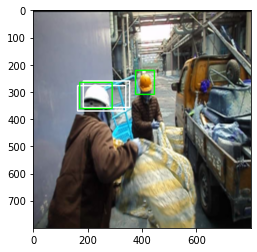

In [ ]:
img_copy5 = np.copy(img_resize)
for i in range(pos_roi_per_this_image):
    y0, x0, y1, x1 = roi_vals[pos_index[i]].astype(int)
    cv2.rectangle(img_copy5, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bb_resizedval)):
    cv2.rectangle(img_copy5, (bb_resizedval[i][1], bb_resizedval[i][0]), (bb_resizedval[i][3], bb_resizedval[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_copy5)


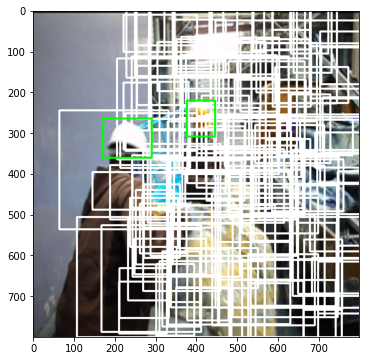

In [ ]:
# display ROI samples with negative 
img_copy6 = np.copy(img_resize)
plt.figure(figsize=(9, 6))
for i in range(neg_roi_per_this_image):
    y0, x0, y1, x1 = roi_vals[neg_index[i]].astype(int)
    cv2.rectangle(img_copy6, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bb_resizedval)):
    cv2.rectangle(img_copy6, (bb_resizedval[i][1], bb_resizedval[i][0]), (bb_resizedval[i][3], bb_resizedval[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_copy6)

In [ ]:
keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
sample_roi = roi_vals[keep_index]
print(sample_roi.shape)

# Pick the ground truth objects for these sample_roi and 
# later parameterize as we have done while assigning locations to anchor boxes in section 2.
bbox_for_sampled_roi = bb_resizedval[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width

base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width

(128, 4)
(128, 4)


In [ ]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs.shape)

(128, 4)


In [ ]:
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 4]) torch.Size([128])
torch.Size([128, 5])


In [ ]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [ ]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # Subsampling ratio
rois = rois.long()
num_rois = rois.size(0)
for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = result_feature_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])
output = torch.cat(output, 0)
print(output.size())

torch.Size([128, 512, 7, 7])


In [ ]:
k = output.view(output.size(0), -1)
print(k.shape)

torch.Size([128, 25088])


In [ ]:
roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)])
cls_loc = nn.Linear(4096, 2 * 4)
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2)

In [ ]:
k = roi_head_classifier(k)
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)
print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [ ]:
# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [ ]:
gt_roi_labels

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)
print(roi_cls_loss.shape)

torch.Size([128, 4]) torch.Size([128])
torch.Size([])


In [ ]:
n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

# For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

# take those bounding boxes which have positve labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(roi_loc_loss.sum())

torch.Size([128, 2, 4])
torch.Size([128, 4])
torch.Size([128, 4])
torch.Size([2, 4]) torch.Size([2, 4])
tensor(0.2797, dtype=torch.float64, grad_fn=<SumBackward0>)


In [ ]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)

tensor([[0.8541, 0.8747, 0.7420, 1.9311],
        [0.7427, 1.1085, 0.7450, 1.7334]], dtype=torch.float64,
       grad_fn=<AddBackward0>)


In [ ]:
total_loss = rpn_loss + roi_loss
print(total_loss)

tensor([[4.7590, 4.7796, 4.6469, 5.8360],
        [4.6476, 5.0134, 4.6499, 5.6383]], dtype=torch.float64,
       grad_fn=<AddBackward0>)
